# Team 3 Project - Pooling Type

## Introduction

<div class="alert alert-block alert-info">

Pooling is a concept in convolutional neural networks (CNN), which are an architecture specially suitable for deep learning problems that include images as insputs (e.g. visual object recognition). Pooling goes hand-in-hand with convolution which are also essential in CNN.

The idea is that a convolution (or a local neural network feature detector) maps a region of an image to a feature map. For example a 4x4 array of pixels could be mapped to oriented edge features. The convolution is repeated over-and-over at all possible pixel locations in what is sometimes called a "sliding rectangle."
</div>


<img src='https://i.stack.imgur.com/bhXRN.png' />

<div class="alert alert-block alert-info">

Why do we perform pooling? Answer: To reduce variance, reduce computation complexity (as 2*2 max pooling/average pooling reduces 75% data) and extract low level features from neighbourhood

</div>

<img src='https://qph.fs.quoracdn.net/main-qimg-3a8a3a78734fed3301ed3546634b871a.webp' />



## Max Pooling vs Average Pooling

<div class="alert alert-block alert-info">

Max pooling extracts the most important features like edges whereas, average pooling extracts features so smoothly.  Although both are used for same reason, max pooling is better for extracting the extreme features. Average pooling sometimes can’t extract good features because it takes all into count and results an average value which may be or may not be important for object detection type tasks. Average pooling brings all into account and flows it to next layer which means all values are actually  used for feature mapping and creating output - which is a very generalized computation.

</div>

## Project explanation

<div class="alert alert-block alert-info">
First, we import the necessary libraries for our project
</div>

In [7]:
%matplotlib inline
import numpy as np
import time
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten
from keras.datasets import mnist
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.optimizers import Adam

<div class="alert alert-block alert-info">
We load the MNIST dataset and normalize the values
</div>

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train / 255.
X_test = X_test / 255.
X_train_red = X_train[:round(X_train.shape[0]*0.8),:,:,:]
X_val = X_train[round(X_train.shape[0]*0.8):,:,:,:]
print(X_train.shape)
print(X_train_red.shape)
print(X_val.shape)

(60000, 28, 28, 1)
(48000, 28, 28, 1)
(12000, 28, 28, 1)


<div class="alert alert-block alert-info">
Encode the labels as one-hot vectors
</div>

In [3]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train_red = y_train[:round(X_train.shape[0]*0.8),:]
y_val = y_train[round(X_train.shape[0]*0.8):,:]
num_classes = y_test.shape[1]

<div class="alert alert-block alert-info">

Definition of a function that allows to compute the needed memory of a model
</div>

In [4]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

<div class="alert alert-block alert-info">

We define a function to create and train our model based on the parameter we pass to that function. This parameter will be the type of pooling we want to test.

</div>

In [13]:
def test(param):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    if param:
        model.add(param)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    train_start = time.time()
    history = model.fit(X_train_red, y_train_red, validation_data=(X_val, y_val), epochs=20, batch_size=200, verbose=0)
    train_end = time.time()
    train_time = train_end-train_start
    scores = model.evaluate(X_test, y_test, verbose=0)
    test_time = time.time()-train_end
    gbytes = get_model_memory_usage(200, model)
    return history, scores, gbytes, train_time, test_time

<div class="alert alert-block alert-info">

Using our test function, we create and train 3 models with the three Pooling types (Max, Average and No pooling).

</div>

In [14]:
history_average, scores_average , gbytes_average, average_train_time, average_test_time = test(AveragePooling2D(pool_size=(2, 2)))
print("Elapsed time training with average pooling: %s seconds" % average_train_time)
print("Elapsed time predicting with average pooling: %s seconds" % average_test_time)
print("Baseline Error with average pooling: %.2f%%" % (100-scores_average[1]*100))
print("Memory footprint with average pooling: %f GB \n" % gbytes_average)

history_max, scores_max, gbytes_max, max_train_time, max_test_time = test(MaxPooling2D(pool_size=(2, 2)))
print("Elapsed time training with maximum pooling: %s seconds" % max_train_time)
print("Elapsed time predicting with maximum pooling: %s seconds" % max_test_time)
print("Baseline Error with maximum pooling: %.2f%%" % (100-scores_max[1]*100))
print("Memory footprint with maximum pooling: %f GB \n" % gbytes_max)

history_null, scores_null, gbytes_null, null_train_time, null_test_time = test(None)
print("Elapsed time training without pooling: %s seconds" % null_train_time)
print("Elapsed time predicting without pooling: %s seconds" % null_test_time)
print("Baseline Error without pooling: %.2f%%" % (100-scores_null[1]*100))
print("Memory footprint without pooling: %f GB" % gbytes_null)

Elapsed time training with average pooling: 58.84272885322571 seconds
Elapsed time predicting with average pooling: 0.7220156192779541 seconds
Baseline Error with average pooling: 1.19%
Memory footprint with average pooling: 0.465000 GB 

Elapsed time training with maximum pooling: 58.2192964553833 seconds
Elapsed time predicting with maximum pooling: 0.7124764919281006 seconds
Baseline Error with maximum pooling: 1.19%
Memory footprint with maximum pooling: 0.465000 GB 

Elapsed time training without pooling: 77.23744487762451 seconds
Elapsed time predicting without pooling: 0.7018535137176514 seconds
Baseline Error without pooling: 1.10%
Memory footprint without pooling: 1.801000 GB


<div class="alert alert-block alert-info">

We define a single function to plot the accuracy and the loss of our models. Based on the label we pass as a parameter, the function will plot the training or validation results of each model.

</div>

In [15]:
def plot(label):
    type_list = [history_max, history_average, history_null]
    label_list = ['MAX', 'AVERAGE', 'NONE']
    
    if label == 'validation accuracy':
        key = 'val_acc'
    elif label == 'training accuracy':
        key = 'acc'
    elif label == 'validation loss':
        key = 'val_loss'
    else:
        key = 'loss'
        
    for item, description in zip(type_list, label_list):
        plt.plot(item.history[key], label=label + ' '+description) 
        
    plt.legend()
    plt.title(label)
    plt.show()

<div class="alert alert-block alert-info">

Finally, we use our plot function to see the accuracy and loss results of our models.

</div>

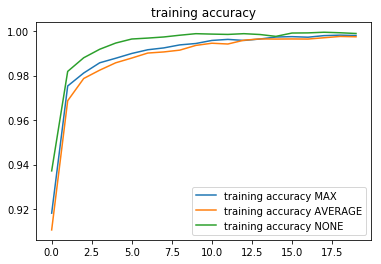

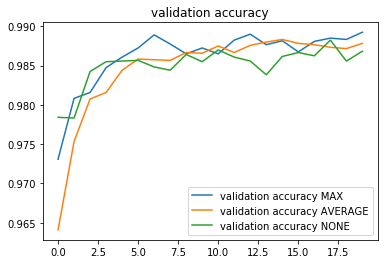

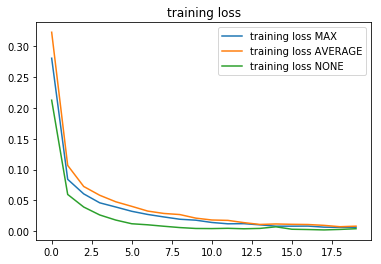

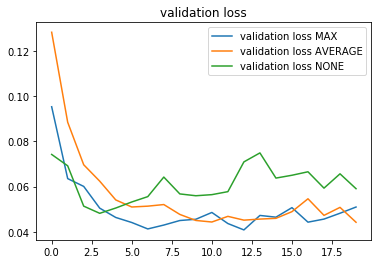

In [16]:
plot('training accuracy')
plot('validation accuracy')
plot('training loss')
plot('validation loss')

# CONCLUSIONS

<div class="alert alert-block alert-info">
<p>
Based on the training accuracy and loss, it seems that the model with No Pooling gets the best results. But as soon as we check the validation results, we can see that the Average Pooling model is the best one, followed by the Max Pooling model. It seems a case of overfitting, but when evaluating the test dataset which is composed by unseen samples, the lower baseline error is obtained without Pooling.
</p>

<p>
Run-time of the training step is faster when a Pooling Layer is added as the convolution operation has less input parameters (in fact they drop by a factor 4 as Stride is set to 2 in both dimensions). However, prediction time is almost the same in all cases so once the model is trained this is not a constrait.
</p>

<p>
Memory usage was also evaluated and the models with Pooling Layers were found to need only the 25% of the total memory that is needed without Pooling. This is due to the increase in number of parameters that also corresponds to 4 times more (with a Pooling layer, the number of parameters drop by a factor 4 as Stride is set to 2 in both dimensions).
</p>

<p>
We realise the importance of tuning the parameters and having independent databases to train, test and validate the model. We also found that more parameters doesn't mean better performance in some cases so ther is a trade-off to avoid both overfitting and underfitting. Taking into account all the previous metrics, we consider that best in our case is to use a Max Pooling Layer, bu this depends on the nature of each problem and its application (limited memory resources, only caring about getting the lowest error rate,etc.)
</p>


</div>